<a href="https://colab.research.google.com/github/celneo7/NUS-SDS-Datathon-Champion-Group-116/blob/main/NUS_DATATHON_CHAMPION_Group_116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install joblib
#%pip install scikit-learn
#%pip install xgboostdddddd
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer

import joblib


filepath = "./data/catA_train.csv"
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

C:\Users\CelesteN\AppData\Local\Temp\ipykernel_14212\1579822264.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### **ALL** Code for machine learning and dataset analysis should be entered below.
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [ ]:
###...code...###

# Load dataset
df = pd.read_csv(filepath)

In [ ]:
df.head()

,LATITUDE,LONGITUDE,AccountID,Company,SIC Code,Industry,8-Digit SIC Code,8-Digit SIC Description,Year Found,Entity Type,...,Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Import/Export Status,Fiscal Year End,Global Ultimate Company,Global Ultimate Country,Domestic Ultimate Company,Is Domestic Ultimate,Is Global Ultimate
0,1.285495,103.843852,LAKB2BID4559214,FRANK CONSULTING SERVICES PRIVATE LIMITED,7361.0,Employment Agencies,73610000.0,Employment agencies,2020.0,Subsidiary,...,NaN,2.209224e+06,4.637871e+06,NaN,NaN,FINDERS HOLDCO LIMITED,United Kingdom,FRANK RECRUITMENT GROUP PRIVATE LTD.,0.0,0.0
1,1.291294,103.827476,LAKB2BID7610849,NEW DESERT ORCHID SHIPPING PTE. LTD.,4449.0,"Water Transportation of Freight, Not Elsewhere...",44490000.0,Water transportation of freight,2015.0,Subsidiary,...,100.0,7.093536e+09,7.093536e+09,NaN,NaN,PETREDEC PTE. LIMITED,Singapore,NaN,0.0,0.0
2,1.300144,103.857517,LAKB2BID5461679,2MBAO BIOCELLBANK PTE. LTD.,6719.0,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.0,"Holding companies, nec",1993.0,Subsidiary,...,4.0,1.026308e+06,1.026308e+06,NaN,NaN,MADISON LIGHTERS AND WATCHES CO LTD,Hong Kong SAR,2MBAO BIOCELLBANK PTE. LTD.,1.0,0.0
3,1.300785,103.791263,LAKB2BID5088529,NEWBLOOM PTE. LTD.,6719.0,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.0,"Holding companies, nec",2006.0,Subsidiary,...,100.0,7.339898e+10,7.339898e+10,NaN,NaN,WILMAR INTERNATIONAL LIMITED,Singapore,WILMAR INTERNATIONAL LIMITED,0.0,0.0
4,1.298759,103.859430,LAKB2BID1268831,ASIA GREEN CAPITAL PTE. LTD.,6719.0,"Offices of Holding Companies, Not Elsewhere Cl...",67190000.0,"Holding companies, nec",2006.0,Parent,...,4.0,4.322130e+05,4.322130e+05,Exports,NaN,ASIA GREEN CAPITAL PTE. LTD.,Singapore,ASIA GREEN CAPITAL PTE. LTD.,1.0,1.0


# Data Cleaning

In [ ]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Drop redundant rows (too many NAs or unique keys so only one relevant column needed)
df.drop(['LATITUDE', 'LONGITUDE', '8-Digit SIC Description',
       'Fiscal Year End', 'AccountID'], axis = 1, inplace = True)

In [ ]:
# Filling in NA values with appropriate ones
for col in df.columns:
  if df[col].dtype != np.float64:
    df[col] = df[col].fillna("nan")
  else:
    df[col] = df[col].fillna(0)

In [ ]:
# encode data by changing low frequency values to "Others"

for col in df.columns:
  column = df[col]
  # Find the frequency of each unique value
  freq = column.value_counts()
  if freq.size > 10 and column.dtype != np.float64 and freq.mean() > 1: # non-categorical & not already sorted to top 10 & not unique keys

      # find threshold for omitting data
      ratio_cumsum = freq.cumsum()/ sum(freq)
      thres = 0
      if freq.size > 5000: # convert more rows to "others" if more unique values
        thres = 0.60
      else:
        thres = 0.90

      # Replace these low-frequency SIC Codes with a common label "Others"
      low_freq = freq[ratio_cumsum > thres].index
      df[col] = df[col].replace(low_freq, 'Others').astype(str)

In [ ]:
# correlation matrix for numerical variables (csv version is in drive)
# originally done using radiant, but the output should be identical (code was adapted from sds)
numerical_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_df.corr()

correlation_df = pd.DataFrame(correlation_matrix)["Sales (Domestic Ultimate Total USD)"]

print(correlation_df)

SIC Code                              -0.011493
8-Digit SIC Code                      -0.011480
Year Found                             0.006493
Square Footage                              NaN
Employees (Single Site)                0.003350
Employees (Domestic Ultimate Total)    0.016905
Employees (Global Ultimate Total)     -0.003558
Sales (Domestic Ultimate Total USD)    1.000000
Sales (Global Ultimate Total USD)      0.098110
Is Domestic Ultimate                  -0.054561
Is Global Ultimate                    -0.039314
Name: Sales (Domestic Ultimate Total USD), dtype: float64


**Relationship between total global sales in USD and total global employee numbers**

Inspection of the correlation coefficient between total global sales in USD and total global employee numbers shows that the two variables have no clear linear relationship.
However, the natural logarithms of both variables appear to be linearly correlated with each other, as can be seen from the plot below.

Global Sales vs emp plot(radiant).png

By performing linear regression on the data above, a regression line of $Y=1.061  X + 12.293$ was obtained.

Hence, it was determined that total global sales in USD (y) and total global employee numbers (x) were related by the equation $y=218163x^{1.061}$

**Relationship between total domestic sales in USD and total domestic employee numbers**

Similar to the relationship between global sales and employee figures, their domestic counterparts also appear to be correlated in the same way. (see figure below)

By evaluating the natural logarithms of the total domestic sales in USD and that of the total domestic employee numbers and performing linear regression on the resulting data, we obtained a regression line with equation

$Y=1.076X + 12.337$

Hence, it was determined that total domestic sales in USD (y) and total domestic employee numbers (x) were related by the equation

$y=227977x^{1.076}$



Domestic sales vs employees (Radiant Plot).png

**Domestic Sales by Industry**

The Standard Industrial Classification (SIC) system assigns an industry code to each industry. These codes can be broadly categorised as follows:

1. Finance, Insurance and Real Estate

2. Wholesale Trade

3. Construction

4. Manufacturing

5. Mining

6. Public Administration

7. Retail Trade

8. Services

9. Transportation, Communications, Electric. Gas and Sanitary

Using the Radiant software, we obtained the following bar plot of mean domestic total sales across the aforementioned industry types.

As can be seen from the plot, the transportation and utilities industries yielded the highest domestic sales over the 2018 - 2023 period (as given in the dataset). This is to be expected due to the major roles that these industries play in domestic economies. Due to the effects of climate change and an expected increase in demand for these services, we can expect this sector to continue dominating in the near future.

domestic_sales_vs_industry.png

# Machine Learning

In [ ]:
# Get x and y values
y = df['Sales (Domestic Ultimate Total USD)']
X = df.drop(['Sales (Domestic Ultimate Total USD)'], axis = 1)


# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [ ]:
# Categorise
num_col = ['Year Found', 'Employees (Single Site)',
       'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Global Ultimate Total USD)']

cat_col = ['Company', 'SIC Code', 'Industry', 'Import/Export Status',
       '8-Digit SIC Code',
       'Entity Type', 'Parent Company', 'Parent Country', 'Ownership Type',
       'Company Description',
       'Company Status (Active/Inactive)','Global Ultimate Company', 'Global Ultimate Country',
       'Domestic Ultimate Company']  # List all categorical columns

In [ ]:
# Preprocessing for categorical data: OneHotEncoding
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor that only encodes the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', QuantileTransformer(), num_col),
        ('cat', categorical_preprocessor, cat_col)
    ],
)

In [ ]:
# Create a pipeline that first preprocesses the data and then applies the model
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor())
])

param_grid = {
    'model__n_estimators': [200, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [5, 6, 7],
    'model__min_child_weight': [4],
    'model__silent': [1],
    'model__subsample': [0.7],
    'model__colsample_bytree': [0.7],
}



# GridSearchCV
mod = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring= ['neg_mean_squared_error', 'r2'], refit = 'r2', return_train_score=True,  cv=5, verbose=1, n_jobs=-1)


In [ ]:
# Fit the model using the preprocessed training data
mod.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:25:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         QuantileTransformer(),
                                                                         ['Year '
                                                                          'Found',
                                                                          'Employees '
                                                                          '(Single '
                                                                          'Site)',
                                                                          'Employees '
                                                                          '(Domestic '
                                                                          'Ultimate '
                                                                          'Total)',
                                                                          'Employees '
                                                                          '(Global '
                                                                          'Ultimate '
                                                                          'Total)',
                                                                          'Sales '
                                                                          '(Global '
                                                                          'Ultimate '
                                                                          'Total '
                                                                          'USD)']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Company',
                                                                          'SIC '
                                                                          'C...
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.7],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [5, 6, 7],
                         'model__min_child_weight': [4],
                         'model__n_estimators': [200, 300, 500],
                         'model__silent': [1], 'model__subsample': [0.7]},
             refit='r2', return_train_score=True,
             scoring=['neg_mean_squared_error', 'r2'], verbose=1)

In [ ]:
# Evaluate the model on the preprocessed test data
model_score = mod.score(X_test, y_test)

# Display the score
print("Model Score on Test Data:", model_score)

Model Score on Test Data: 0.9734248369993317


In [ ]:
# best model with the best parameters
best_model = mod.best_estimator_
mod.best_params_

{'model__colsample_bytree': 0.7,
 'model__learning_rate': 0.2,
 'model__max_depth': 6,
 'model__min_child_weight': 4,
 'model__n_estimators': 500,
 'model__silent': 1,
 'model__subsample': 0.7}

In [ ]:
features = mod.best_estimator_.steps[1][1].feature_importances_

In [ ]:
# Identify transformed feature names after preprocessing
transformed_feature_names = num_col + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_col))
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': features})

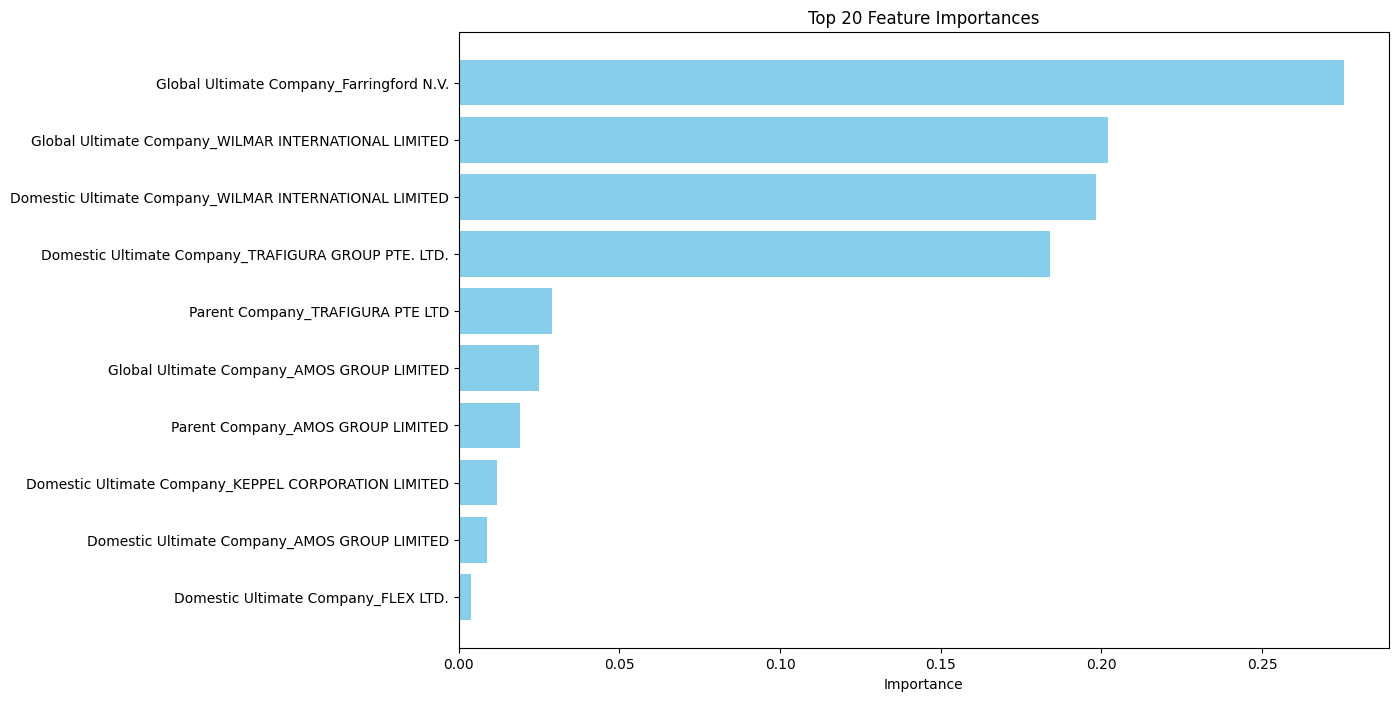

In [ ]:
top_10_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 features
plt.figure(figsize=(12, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In conclusion, our predictive model has identified Global Ultimate Company, Domestic Ultimate Company and Parent Company as key features in influencing sales outcomes, providing valuable insights into trends and patterns within the dataset.


We have also found that partnership with these entities like Farringford N.V., WILMAR INTERNATIONAL LTD., TRAFIGURA GROUP PTE., and AMOS GROUP LIMITED are especially influencial in sales outcomes.

# Saving training model

In [ ]:
import joblib

# Save the base model to an HDF5 file
joblib.dump(mod, 'base_model.h5')

['base_model.h5']



```
`# This is formatted as code`
```

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [1]:
import pandas as pd
import numpy as np


import joblib

def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list) of predictions as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform.

All relevant code MUST be included in this function.'''

    # Remove duplicate rows
    hidden_data.drop_duplicates(inplace=True)

    # Drop redudant rows (too many NAs or unique keys so only one relevant column needed)
    hidden_data.drop(['LATITUDE', 'LONGITUDE', '8-Digit SIC Description',
       'Fiscal Year End', 'AccountID'], axis = 1, inplace = True)


    # Filling in NA values with appropriate ones
    for col in hidden_data.columns:
      if hidden_data[col].dtype != np.float64:
        hidden_data[col] = hidden_data[col].fillna("nan")
      else:
        hidden_data[col] = hidden_data[col].fillna(0)

    # encode data by changing low frequency values to "Others"

    for col in hidden_data.columns:
      column = hidden_data[col]
      # Find the frequency of each unique value
      freq = column.value_counts()
      if freq.size > 10 and column.dtype != np.float64 and freq.mean() > 1: # non-categorical & not already sorted to top 10 & not unique keys

          # find threshold for omitting data
          ratio_cumsum = freq.cumsum()/ sum(freq)
          thres = 0
          if freq.size > 5000: # convert more rows to "others" if more unique values
            thres = 0.60
          else:
            thres = 0.90

          # Replace these low-frequency SIC Codes with a common label "Others"
          low_freq = freq[ratio_cumsum > thres].index
          hidden_data[col] = hidden_data[col].replace(low_freq, 'Others').astype(str)


    # load_model function
    loaded_model = joblib.load('./base_model.h5')
    predictions = loaded_model.predict(hidden_data)

    return predictions

C:\Users\CelesteN\AppData\Local\Temp\ipykernel_16620\339029449.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


##### Cell to check testing_hidden_data function

In [4]:
# This cell should output a list of predictions.
## takes close to 2 minutes to execute
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

[-1.7888534e+06  6.5176909e+09  4.0174808e+06 ...  8.6948900e+06
  1.3076160e+07  4.2924848e+07]


### miscellenous

In [ ]:
best_model = mod.best_estimator_

xgboost_model = best_model.named_steps['model']

# Save the XGBoost model to a file
xgboost_model.save_model('xgb_model.json')

# Download the file if you're using Colab
from google.colab import files
files.download('xgb_model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>